Mount Dataset

In [1]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
!unzip traffic-signs-data.zip

--2021-03-13 20:43:05--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 99.86.227.118, 99.86.227.60, 99.86.227.5, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|99.86.227.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip.1’

traffic-signs-data. 100%[===================>] 117.80M  51.7MB/s    in 2.3s    

2021-03-13 20:43:07 (51.7 MB/s) - ‘traffic-signs-data.zip.1’ saved [123524425/123524425]

Archive:  traffic-signs-data.zip
replace test.p? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Add libraries and functions

In [2]:
import pickle
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from skimage.filters import rank
from sklearn.utils import shuffle
import skimage.morphology as morp

import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.utils.data import TensorDataset, DataLoader, Dataset, WeightedRandomSampler
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
from torch.autograd import Variable

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

def calc_gradient_penalty(x, y_pred_sum):
    gradients = torch.autograd.grad(
        outputs=y_pred_sum,
        inputs=x,
        grad_outputs=torch.ones_like(y_pred_sum),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.flatten(start_dim=1)

    # L2 norm
    grad_norm = gradients.norm(2, dim=1)

    # Two sided penalty
    gradient_penalty = ((grad_norm - 1) ** 2).mean()

    return gradient_penalty

Open the dataset

In [3]:
training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

Dataset parameters

In [4]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))


print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


Classes included

In [5]:
signs = """Speed limit (20km/h)
Speed limit (30km/h)
Speed limit (50km/h)
Speed limit (60km/h)
Speed limit (70km/h)
Speed limit (80km/h)
End of speed limit (80km/h)
Speed limit (100km/h)
Speed limit (120km/h)
No passing
No passing for vehicles over 3.5 metric tons
Right-of-way at the next intersection
Priority road
Yield
Stop
No vehicles
Vehicles over 3.5 metric tons prohibited
No entry
General caution
Dangerous curve to the left
Dangerous curve to the right
Double curve
Bumpy road
Slippery road
Road narrows on the right
Road work
Traffic signals
Pedestrians
Children crossing
Bicycles crossing
Beware of ice/snow
Wild animals crossing
End of all speed and passing limits
Turn right ahead
Turn left ahead
Ahead only
Go straight or right
Go straight or left
Keep right
Keep left
Roundabout mandatory
End of no passing
End of no passing by vehicles over 3.5 metric tons""".split('\n')

Dataset exploration

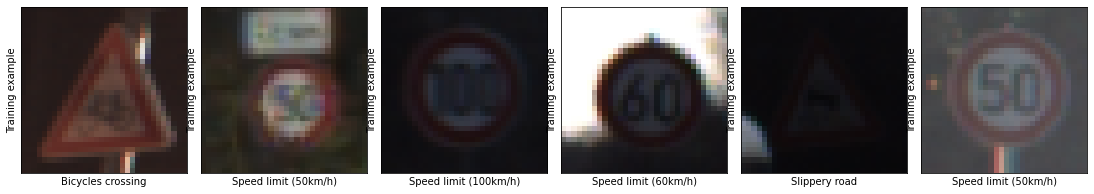

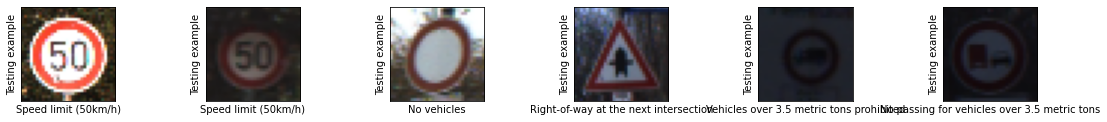

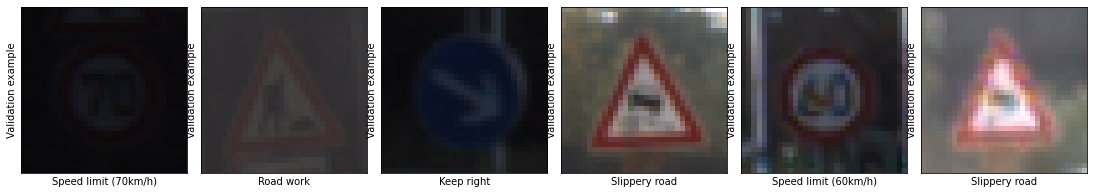

In [6]:
def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
# Plotting sample examples
list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")
list_images(X_valid, y_valid, "Validation example")

Show All

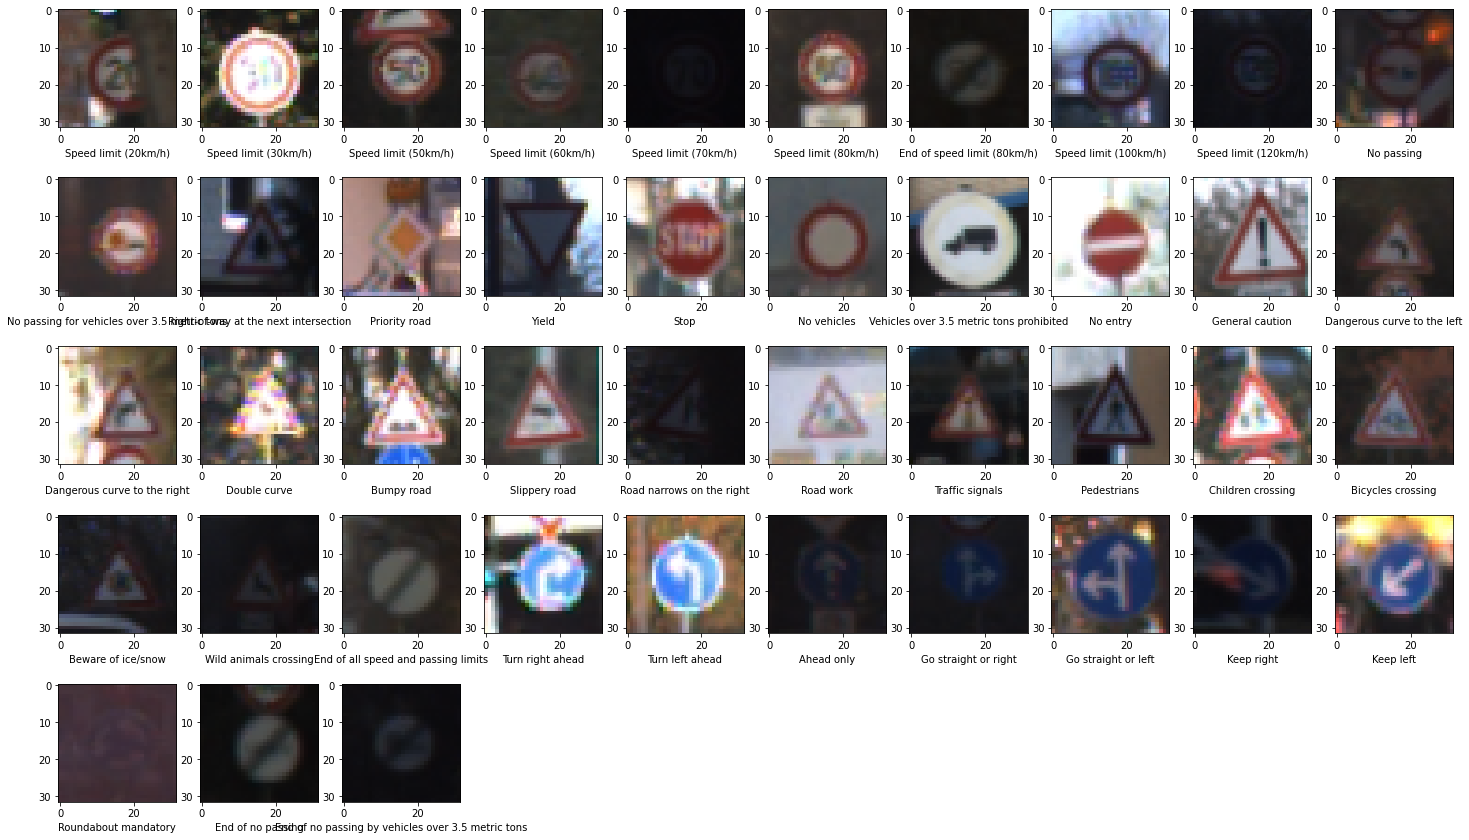

In [7]:
imgs = [None]*43
st = [False]*43
for i in range(len(X_valid)):
  if(not st[y_valid[i]]):
    st[y_valid[i]] = True
    imgs[y_valid[i]]= X_valid[i]

plt.figure(figsize=(25, 15))
for i in range(43):
  plt.subplot(5,10, i+1)
  plt.imshow(imgs[i],interpolation='nearest',)
  plt.xlabel(signs[i])
plt.show()

Hyperparameters

In [8]:
n_epochs = 35

batchsize = 64

Pre-processing

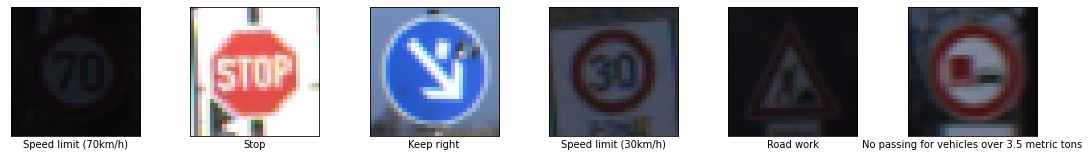

In [9]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local
def scale(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image
def preprocess(X_train, y_train):
  print(X_train.shape)
  X_train, y_train = shuffle(X_train, y_train)
  gray_images = np.array(list(map(gray_scale, X_train)))
  equalized_images =  np.array(list(map(local_histo_equalize, gray_images)))
  X_train  = np.array(list(map(image_normalize, equalized_images)))
 
  return X_train, y_train


X_train = scale(X_train)
X_valid = scale(X_valid)
X_test = scale(X_test)
#X_train, y_train = preprocess(X_train, y_train)
#X_valid, y_valid = preprocess(X_valid, y_valid)
#X_test, y_test = preprocess(X_test, y_test)
list_images(X_train, y_train)

Transforms

In [10]:
data_flip = transforms.Compose([
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.Normalize(0,1)
     #AddGaussianNoise(0., 10/255)
])
test_transform = transforms.Compose([
     transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])


# Resize, normalize and jitter image brightness
data_jitter_brightness = transforms.Compose([
	  transforms.Resize((32, 32)),
    transforms.ColorJitter(brightness=5),
    transforms.Normalize(0,1)
])


# Resize, normalize and rotate image
data_rotate = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomRotation(15),
    transforms.Normalize(0,1)
])


# Resize, normalize and shear image
data_shear = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomAffine(degrees = 15,shear=2),
    transforms.Normalize(0,1)
])

# Resize, normalize and translate image
data_translate = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.RandomAffine(degrees = 15,translate=(0.1,0.1)),
    transforms.Normalize(0,1)
])

# Resize, normalize and crop image 
data_center = transforms.Compose([
	  transforms.Resize((36, 36)),
    transforms.CenterCrop(32),
    transforms.Normalize(0,1)
])
# Resize, normalize and jitter image saturation
data_jitter_saturation = transforms.Compose([
	  transforms.Resize((32, 32)),
    transforms.ColorJitter(saturation=5),
    transforms.Normalize(0,1)
])

# Resize, normalize and jitter image contrast
data_jitter_contrast = transforms.Compose([
	  transforms.Resize((32, 32)),
    transforms.ColorJitter(contrast=5),
    transforms.Normalize(0,1)
    ])

# Resize, normalize and jitter image hues
data_jitter_hue = transforms.Compose([
	transforms.Resize((32, 32)),
    transforms.ColorJitter(hue=0.4),
    transforms.Normalize(0,1)
])


class PyTorchImageDataset(Dataset):
    def __init__(self, image_list, labels, transforms=None):
        self.image_list = torch.Tensor(np.rollaxis(image_list.reshape(-1,32,32,3),3,1) )
        self.labels = torch.Tensor(labels)
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.image_list))
    
    def __getitem__(self, i):
        image = self.image_list[i]
        if self.transforms is not None:
            image = self.transforms(image)
        return (image,self.labels[i])


Making the dataset and loaders

In [11]:
train_ds = PyTorchImageDataset(X_train,y_train)
#torch.utils.data.ConcatDataset([#PyTorchImageDataset(X_train,y_train, transforms = data_jitter_brightness),
                                           #PyTorchImageDataset(X_train,y_train, transforms = data_rotate),
                                           #PyTorchImageDataset(X_train,y_train, transforms = data_flip),
                                           #PyTorchImageDataset(X_train,y_train, transforms = data_center),
                                           #PyTorchImageDataset(X_train,y_train, transforms = data_translate),
                                           #yTorchImageDataset(X_train,y_train, transforms = data_shear),
                                           #PyTorchImageDataset(X_train,y_train, transforms = test_transform)])
test_ds = PyTorchImageDataset(X_test,y_test)
val_ds = PyTorchImageDataset(X_valid,y_valid)


class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

train_loader = DataLoader(train_ds,batchsize,shuffle = True);
test_loader = DataLoader(test_ds,X_test.shape[0]);
val_loader = DataLoader(val_ds,X_valid.shape[0]);

MODEL

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.checkpoint import checkpoint

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            # inplace=True -> сохранить немного памяти
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=14),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128,128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=6),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5)
        )
        
        self.fc = nn.Sequential(
            #nn.Linear(128 * 1 * 1, 128),
            
            #nn.Linear(64, n_classes),

#             хуже????
#             nn.Softmax(dim=1)
        )

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
            )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2),
            )
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))


    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def compute_features(self, x):
        # transform the input
        x = self.stn(x)
        self.datain = x
        # Perform forward pass
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #print(x.shape)
        x = x.view(-1, 256 * 2 * 2)
        
        x = self.fc(x)
        return x



class CNN_DUQ(Net):
    def __init__(
        self,
        input_size,
        num_classes,
        centroid_size,
        model_output_size,
        length_scale,
        gamma,
        input_dep_ls=False
    ):
        super().__init__()

        self.gamma = gamma
        self.input_dep_ls=input_dep_ls

        self.W = nn.Parameter(
            torch.zeros(centroid_size, num_classes, model_output_size)
        )
        nn.init.kaiming_normal_(self.W, nonlinearity="relu")


        self.register_buffer("N", torch.zeros(num_classes) + 13)
        self.register_buffer(
            "m", torch.normal(torch.zeros(centroid_size, num_classes), 0.05)
        )
        self.m = self.m * self.N
        
        if input_dep_ls:
            
            self.sigmann = nn.Sequential(
              nn.Linear(model_output_size, 100),
              nn.ReLU(True),
              nn.Dropout2d(0.35),
              nn.Linear(100, 1),
            )
        self.sigma = length_scale*length_scale

    def rbf(self, z):
    
        if self.input_dep_ls:
            self.sigma = torch.sigmoid(self.sigmann(z)/50)+0.001

        z = torch.einsum("ij,mnj->imn", z, self.W)

        embeddings = self.m / self.N.unsqueeze(0)

        diff = z - embeddings.unsqueeze(0)
        diff = (- diff ** 2).mean(1).div(2 * (self.sigma)).exp()

        return diff

    def update_embeddings(self, x, y):
        self.N = self.gamma * self.N + (1 - self.gamma) * y.sum(0)

        z = self.compute_features(x)

        z = torch.einsum("ij,mnj->imn", z, self.W)
        embedding_sum = torch.einsum("ijk,ik->jk", z, y)

        self.m = self.gamma * self.m + (1 - self.gamma) * embedding_sum

    def forward(self, x):
        z = self.compute_features(x)
        y_pred = self.rbf(z)
        
        return y_pred

length_scale = 0.6
input_size = 32
num_classes = 43
output_size = 256*2*2
embedding_size = 100
learnable_length_scale = False #Learnable length scale
gamma = 0.999
input_dep_ls = True
torch.cuda.empty_cache()
network = []
network = CNN_DUQ(input_size,num_classes,embedding_size,output_size,length_scale,gamma,input_dep_ls).float().cuda()

Training and testing

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
valid_df = []
test_df = []
vlogit = []
tlogit = []

def train(model, train_loader, epochs, cudav):

  learning_rate = 0.0005
  momentum = 0.1
  weight_decay = 0.0001
  lm = 0.1
  log_interval = 20
  optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=learning_rate,weight_decay=weight_decay)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer,[8,10,14],0.5)

  for epoch in range(epochs):
    loss_=[]
    correct_=0

    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = Variable(data), Variable(target).long()
      if cudav :
        torch.cuda.empty_cache()
        data=data.cuda(); target=target.cuda();
      model.train()

      optimizer.zero_grad()
      output = model(data)
      pred = output.data.argmax(1).long()
      datain = model.datain
      loss = 10*F.binary_cross_entropy(output, F.one_hot(target,43).float()) + lm*calc_gradient_penalty(datain,output.sum(1)) 
      correct = pred.eq(target.data.view_as(pred)).sum().item()
      loss.backward()
      optimizer.step()

      loss_.append(loss.item())
      correct_+=correct

      with torch.no_grad():
        model.eval()
        model.update_embeddings(data,F.one_hot(target.long(),43).float())

      if batch_idx % log_interval == 0:
        trainlog(batch_idx,100.*correct/len(data),loss.item())

    trainlog(epoch,100.*correct_/len(train_loader.dataset),np.array(loss_).mean())
    scheduler.step()

  if cudav:
    torch.cuda.empty_cache()



def validation(model,val_loader,cudav):
  model.eval()
  global vlogit, valid_df
  criterion = nn.CrossEntropyLoss()
  y_true = []
  y = []
  y_conf = []
  logits = []
  val_loss_ = []
  correct_ = 0

  with torch.no_grad():
    for _,(data, target) in enumerate(val_loader):
      target = target.long()
      if cudav:
        torch.cuda.empty_cache()
        data = data.cuda()
        target = target.cuda()

      output = model(data)
      pred = output.data.argmax(1).long()
      conf = output.data.max(1)[0]

      val_loss = criterion(output, target.long()).item()
      correct = pred.eq(target.long().data.view_as(pred)).sum().item()
      val_loss_.append(val_loss)
      correct_+=correct

      logits.append(output.cpu().numpy())
      y_true.append(target.cpu().numpy())
      y_conf.append(conf.cpu().numpy())
      y.append(pred.cpu().numpy())

  y_true = np.hstack(y_true)
  y_conf = np.hstack(y_conf)
  y = np.hstack(y)
  vlogit = np.hstack(logits)
  data = np.column_stack([y_true, y, y_conf])

  global valid_df
  valid_df = pd.DataFrame(data=data,columns=['label','pred','conf'])

  trainlog(1,100.*correct_/len(val_loader.dataset),np.array(val_loss_).mean())
  if cudav:
    torch.cuda.empty_cache()



def test(model,test_loader, cudav):
  model.eval()
  global tlogit, test_df
  criterion = nn.CrossEntropyLoss()
  y_true = []
  y = []
  y_conf = []
  logits = []
  test_loss_ = []
  correct_ = 0

  with torch.no_grad():
    for _,(data, target) in enumerate(test_loader):
      target = target.long()
      if cudav:
        torch.cuda.empty_cache()
        data = data.cuda()
        target = target.cuda()

      output = model(data)
      pred = output.data.argmax(1).long()
      conf = output.data.max(1)[0]

      test_loss = criterion(output, target.long()).item()
      correct = pred.eq(target.data.view_as(pred)).sum().item()
      test_loss_.append(test_loss)
      correct_+=correct

      logits.append(output.cpu().numpy())
      y_true.append(target.cpu().numpy())
      y_conf.append(conf.cpu().numpy())
      y.append(pred.cpu().numpy())

  y_true = np.hstack(y_true)
  y_conf = np.hstack(y_conf)
  y = np.hstack(y)
  tlogit = np.hstack(logits)
  data = np.column_stack([y_true, y, y_conf])

  test_df = pd.DataFrame(data=data,columns=['label','pred','conf'])
  trainlog(1,100.*correct_/len(test_loader.dataset),np.array(test_loss_).mean())
  print("f1 = ", f1_score(y_true,y,average="macro"))
  if cudav:
    torch.cuda.empty_cache()



def trainlog(epoch, correct, loss):
  print("epoch = {}, correct = {}, loss = {}".format(epoch,correct,loss));

train(network,train_loader,15,True)
validation(network,val_loader,True)
test(network,test_loader,True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


epoch = 0, correct = 1.5625, loss = 32.235198974609375
epoch = 20, correct = 4.6875, loss = 1.743125081062317
epoch = 40, correct = 4.6875, loss = 1.249992847442627
epoch = 60, correct = 7.8125, loss = 1.1792469024658203
epoch = 80, correct = 9.375, loss = 1.1018487215042114
epoch = 100, correct = 12.5, loss = 1.0906604528427124
epoch = 120, correct = 9.375, loss = 1.0851815938949585
epoch = 140, correct = 4.6875, loss = 1.0981649160385132
epoch = 160, correct = 10.9375, loss = 1.0589066743850708
epoch = 180, correct = 9.375, loss = 1.0708993673324585
epoch = 200, correct = 4.6875, loss = 1.0481868982315063
epoch = 220, correct = 12.5, loss = 1.0283201932907104
epoch = 240, correct = 7.8125, loss = 0.99878990650177
epoch = 260, correct = 17.1875, loss = 0.9619867205619812
epoch = 280, correct = 20.3125, loss = 0.9069677591323853
epoch = 300, correct = 12.5, loss = 0.9914491176605225
epoch = 320, correct = 23.4375, loss = 0.9296069145202637
epoch = 340, correct = 14.0625, loss = 0.94446

# **Visualizing STN**

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


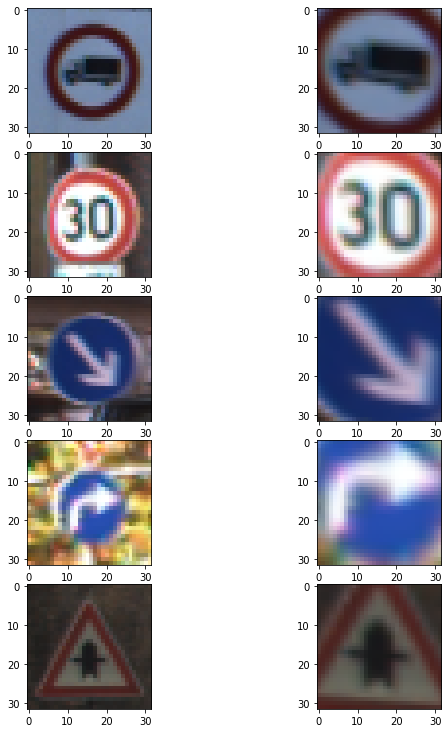

In [48]:
for i, (data,target) in enumerate(test_loader):
  break
network.eval()
a = data[:,:,:,:].detach()
b = network.stn(data[:,:,:,:].cuda()).cpu().detach()[:,:,:,:]
c = target.long()

def norm (a):
    a = (a-a.min())
    a/=(a.max())
    return a+0.00001


num=5
plt.figure(figsize=(10,2*num))
for i in range(num):
  plt.subplot(num,2,i*2+1)
  plt.imshow(a[i].permute(1,2,0))
  plt.subplot(num,2,i*2+2)
  plt.imshow(b[i].permute(1,2,0))
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()


# **Other Plots**

Confusion Matrix

[[1.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.9972 0.     ... 0.     0.     0.    ]
 [0.     0.0027 0.996  ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.9778 0.     0.    ]
 [0.     0.     0.     ... 0.     1.     0.    ]
 [0.     0.     0.     ... 0.     0.0778 0.9   ]]


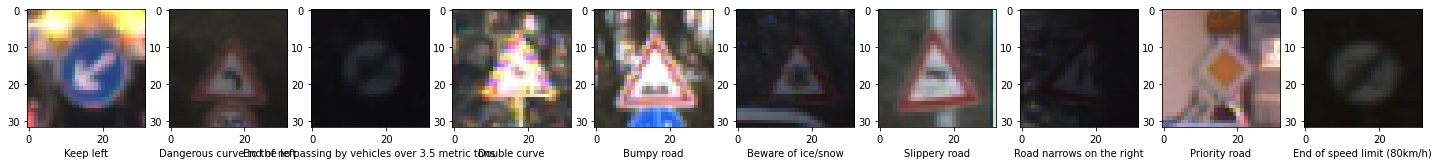

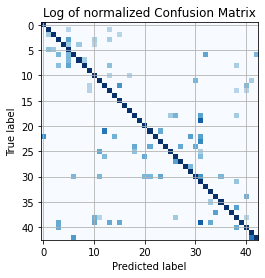

In [47]:
import sys
import numpy

cm = confusion_matrix(test_df['label'],test_df['pred'])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(np.round(cm,4))

mn = []
for i in range (0,43):
  mn.append(cm[i][i])
mn = np.array(mn);
mne = np.argsort(mn)[:10]

plt.figure(figsize=(25, 5))
for i in range(len(mne)):
  plt.subplot(1,10, i+1)
  plt.imshow(imgs[mne[i]],interpolation='nearest',)
  plt.xlabel(signs[mne[i]])
plt.show()

cm = np.log(.0001 + cm)
plt.grid(True,'both')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

ROCs

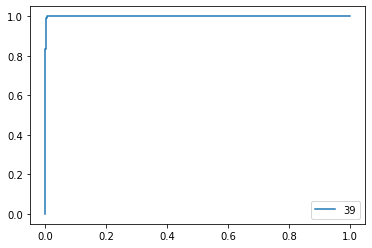

In [53]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, f1_score, roc_curve

def roc(df1, logit):
  data = df1.to_numpy()
  y = label_binarize(data[:, 0], classes=list(np.unique(data[:, 0])))
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], logit[:, i])
    fpr[i] = fpr[i].tolist()
    tpr[i] = tpr[i].tolist()
  return fpr, tpr

i=39
c = roc(test_df,tlogit)
plt.plot(list(c[0].values())[i], list(c[1].values())[i],label=i)
plt.legend([i])
plt.show()

# **Uncertainty Analysis**
Epistemic uncertainty: Shows if the model is not trained on this data variety, or if the data or similar is never seen by the model. This uncertainty score is better than blantly guessing anything
- Low data training
- Improper training
- OoD detection

Aleatoric uncertainty: Shows the noise present in the data

# On full Test Data
Histogram of confidence estimates for correct, wrong classifications, and also for OoD samples

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

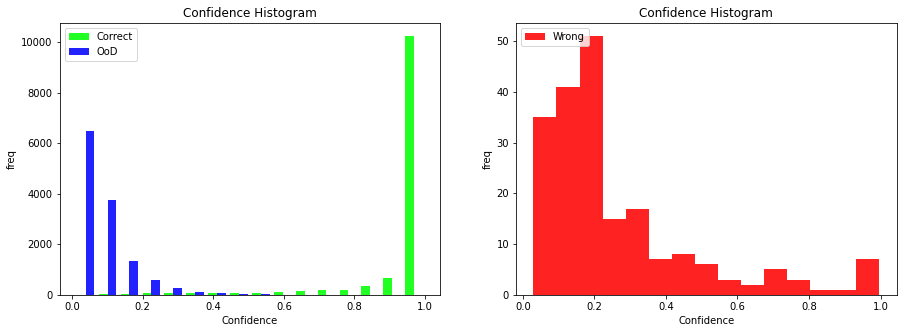

In [45]:
kernel_distace_normal,kernel_distace_wrong,kernel_distace_ood = [],[],[]
network.eval()

e=1
with torch.no_grad():
  for _,(data, target) in enumerate(test_loader):
    output = network(data.cuda())
    output = output.cpu()
    pred = output.argmax(1)
  ood = 0*data + e*torch.randn(data.shape)
  new_output = network(ood.cuda())
  new_output = new_output.cpu();
  newpred = new_output.argmax(1)

for i in range (len(target)):
  if target[i] == pred [i]:
    kernel_distace_normal.append(output[i].max(0)[0].item())
  else:
    kernel_distace_wrong.append(output[i].max(0)[0].item())
kernel_distace_ood = new_output.max(1)[0].tolist()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
n, bins, patches = plt.hist(x=[kernel_distace_normal,kernel_distace_ood], bins='auto', color=['#22FF22','#2222FF'])
plt.xlabel("Confidence"); plt.ylabel("freq"); plt.title("Confidence Histogram")
plt.legend(['Correct','OoD'],loc='upper left')
plt.subplot(1,2,2)
n, bins, patches = plt.hist(x=[kernel_distace_wrong], bins='auto', color=['#FF2222'])
plt.xlabel("Confidence"); plt.ylabel("freq"); plt.title("Confidence Histogram")
plt.legend(['Wrong'],loc='upper left')
plt.show()

# Per Class
Class Estimates for epistemic and aleatoric uncertainties

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


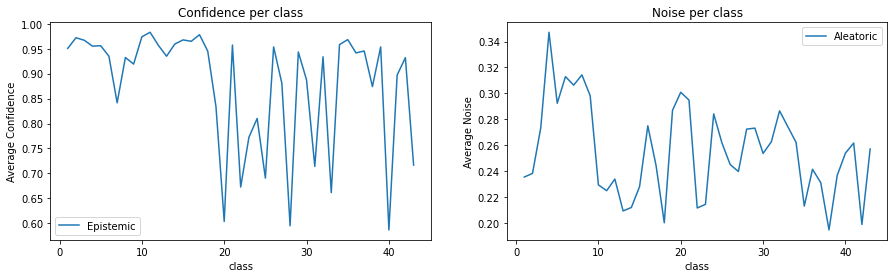

In [44]:
network.eval()
with torch.no_grad():
  for _,(data, target) in enumerate(test_loader):
    output = network(data.cuda())
    output = output.cpu(); 
    sigma = network.sigma.mean(1).cpu()
    target = target.long()

epistemic = np.empty((n_classes, 0)).tolist()
aleatoric = np.empty((n_classes, 0)).tolist()
for i in range (len(target)):
  epistemic[target[i].item()].append(output[i].max(0)[0].item())
  aleatoric[target[i].item()].append(sigma[i].item())
for i in range (n_classes):
  epistemic[i] = np.array(epistemic[i]).mean()
  aleatoric[i] = np.array(aleatoric[i]).mean()


x = np.arange(1,n_classes+1)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(x, epistemic, label = "Epistemic")
plt.xlabel("class"); plt.ylabel("Average Confidence"); plt.title("Confidence per class");
plt.legend()

plt.subplot(1,2,2) 
plt.plot(x, aleatoric, label = "Aleatoric") 
plt.xlabel("class"); plt.ylabel("Average Noise"); plt.title("Noise per class");
plt.legend()
plt.show()

# Per Sample
Show uncertainties per Sample

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for 

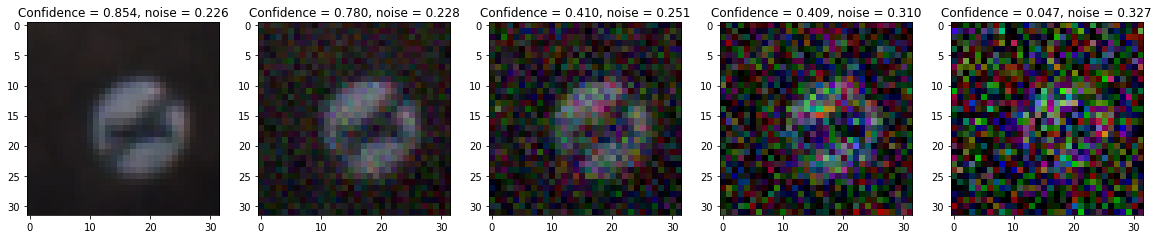

In [43]:
for i, (data,target) in enumerate(test_loader):
  break

er = [0,0.05,0.1,0.2,0.3]
ch = np.random.randint(len(data))
plt.figure(figsize=(4*len(er),4))
for i in range(len(er)):
  e = er[i]
  sample = (data[ch] + e*torch.randn(data[ch].shape))/(1+e)

  network.eval()
  output = network(sample.view(1,3,32,32).cuda()).cpu().view(-1)
  epistemic, aleatoric = output.max(0)[0].mean().item(), abs(network.sigma[0].item())
  
  plt.subplot(1,len(er),i+1)
  plt.imshow(sample.permute(1,2,0))
  plt.title("Confidence = {:.3f}, noise = {:.3f}".format(epistemic, aleatoric))


plt.show()

# Noise Detection

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Text(0, 0.5, 'frequency')

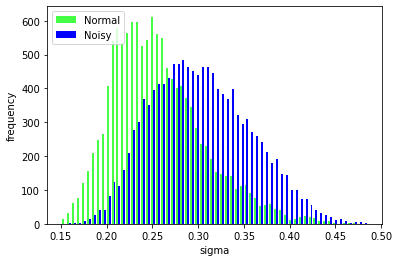

In [31]:
def indx(output,target):
  return -F.nll_loss(output,target.long(),reduce=False)
# indx(network.sigma.cpu(),target)
e = 0.2
torch.cuda.empty_cache()
network.eval()
with torch.no_grad():
  for i, (data,target) in enumerate(test_loader):
    nd = (data + e*torch.randn(data.shape))/(1+e)
    output = network(data.cuda())
   
    sign = network.sigma.cpu()
    newout = network(nd.cuda())
    newsign = network.sigma.cpu()
n, bins, patches = plt.hist(x=[sign.view(-1).numpy(),newsign.view(-1).numpy()], bins='auto', color=['#44FF44','blue'])
plt.legend(['Normal','Noisy'],loc='upper left')
plt.xlabel("sigma")
plt.ylabel("frequency")